
# Q-GAN

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [26]:
import numpy as np

In [27]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned. Then run this command 'pip install -e gym/[all]'.

In [28]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [29]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    if done:
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [30]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
print('rewards min and max:', np.max(np.array(rewards)), np.min(np.array(rewards)))
print('state size:', np.array(states).shape, 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
actions: 1 0
rewards min and max: 1.0 1.0
state size: (10, 4) action size: 2


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [31]:
# Data of the model
def model_input(state_size):
    # Current and next states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Previous and current actions given
    prev_actions = tf.placeholder(tf.int32, [None], name='prev_actions')
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # Qs = qs+ (gamma * nextQs): targetQs is Qs and target_nextQs is nextQs
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    target_nextQs = tf.placeholder(tf.float32, [None], name='target_nextQs')
    
    # returning the given data to the model
    return prev_actions, states, actions, next_states, targetQs, target_nextQs

In [32]:
# Generator: Generating/predicting action and next states
def generator(prev_actions, states, action_size, state_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=(action_size + state_size))
        actions_logits, next_states_logits = tf.split(axis=1, num_or_size_splits=[action_size, state_size], 
                                                      value=logits)
        #predictions = tf.nn.softmax(actions_logits)
        #predictions = tf.sigmoid(next_states_logits)

        # return actions and states logits
        return actions_logits, next_states_logits

In [33]:
def discriminator(prev_actions, states, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusing states and actions
        x_fused = tf.concat(axis=1, values=[prev_actions, states])
        #print(x_fused.shape)
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        #print(h1.shape)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        #print(h2.shape)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)
        #predictions = tf.nn.softmax(logits)

        # return reward logits/Qs
        return logits

In [34]:
# The output of the generator
def model_output(prev_actions, states, actions, next_states, 
                 state_size, action_size, hidden_size):
    # Generator actions and next states
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, _ = generator(prev_actions=prev_actions_onehot, states=states,
                                  hidden_size=hidden_size, state_size=state_size, 
                                  action_size=action_size)
    
    # Generator for nextQs as targetQs
    actions_onehot = tf.one_hot(indices=actions, depth=action_size)
    next_actions_logits, _ = generator(prev_actions=actions_onehot, states=next_states,
                                       hidden_size=hidden_size, state_size=state_size, 
                                       action_size=action_size, reuse=True)
    
    # targetQs masking
    Qs_masked = tf.multiply(actions_logits, actions_onehot)
    Qs = tf.reduce_max(axis=1, input_tensor=Qs_masked)
    nextQs_unmasked = next_actions_logits
    
    # Returning nextQs unmasked to be masked and Qs to be used as targetQs and target_nextQs
    return actions_logits, Qs, nextQs_unmasked

In [35]:
# Calculating the loss of generator based on the generated/predicted states and actions
def model_loss(prev_actions, states, actions, next_states, targetQs, target_nextQs,
               state_size, action_size, hidden_size):
    # Generator actions and next states
    prev_actions_onehot = tf.one_hot(indices=prev_actions, depth=action_size)
    actions_logits, next_states_logits = generator(prev_actions=prev_actions_onehot, states=states,
                                                   hidden_size=hidden_size, state_size=state_size, 
                                                   action_size=action_size, reuse=True)
    
    # Discriminator for nextQs_fake
    #actions_predictions = tf.nn.softmax(actions_logits)
    nextQs_fake_unmasked = discriminator(prev_actions=actions_logits, states=next_states_logits,
                                         hidden_size=hidden_size)
    
    # Discriminator for nextQs_real
    actions_onehot = tf.one_hot(indices=actions, depth=action_size)
    nextQs_real_unmasked = discriminator(prev_actions=actions_onehot, states=next_states,
                                         hidden_size=hidden_size, reuse=True)
    
    # # Masking the unmasked nextQs using dones
    # dones_mask = tf.reshape(tensor=(1 - tf.cast(dtype=nextQs_fake_unmasked.dtype, x=dones)), shape=[-1, 1])
    # nextQs_fake_masked = tf.multiply(nextQs_fake_unmasked, dones_mask)
    # nextQs_real_masked = tf.multiply(nextQs_real_unmasked, dones_mask)
    # nextQs_fake = tf.reduce_max(axis=1, input_tensor=nextQs_fake_masked)
    # nextQs_real = tf.reduce_max(axis=1, input_tensor=nextQs_real_masked)
    #print(nextQs_fake_unmasked.shape, nextQs_real_unmasked.shape, targetQs.shape, target_nextQs.shape)
    targetQs = tf.reshape(targetQs, [-1, 1])
    target_nextQs = tf.reshape(target_nextQs, [-1, 1])
    
        
    # Adverserial learning/training
    g_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_real_unmasked, 
                                                                         labels=tf.sigmoid(targetQs)))
    g_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_fake_unmasked,
                                                                         labels=tf.sigmoid(target_nextQs)))
    # g_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_real_unmasked, 
    #                                                                      labels=tf.zeros_like(targetQs)))
    # g_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_fake_unmasked,
    #                                                                      labels=tf.sigmoid(targetQs)))
    # #g_loss_real = tf.reduce_mean(tf.square(nextQs_real - tf.zeros_like(targetQs)))
    # g_loss_real = tf.reduce_mean(tf.square(nextQs_real))
    # g_loss_fake = tf.reduce_mean(tf.square(nextQs_fake - targetQs))
    g_loss = g_loss_real + g_loss_fake

    # Adverserial learning/training
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_real_unmasked, 
                                                                         labels=tf.sigmoid(target_nextQs)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_fake_unmasked,
                                                                         labels=tf.sigmoid(targetQs)))
    # d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_real_unmasked, 
    #                                                                      labels=tf.sigmoid(targetQs)))
    # d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=nextQs_fake_unmasked,
    #                                                                      labels=tf.zeros_like(targetQs)))
    # d_loss_real = tf.reduce_mean(tf.square(nextQs_real - targetQs))
    # #d_loss_fake = tf.reduce_mean(tf.square(nextQs_fake - tf.zeros_like(targetQs)))
    # d_loss_fake = tf.reduce_mean(tf.square(nextQs_fake))
    d_loss = d_loss_real + d_loss_fake
        
    # Returning the D loss
    return g_loss, d_loss

In [36]:
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss for next state and action prediction
    :param d_loss: Discriminator loss for reward prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Used for BN (batchnorm params)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars) # action prediction
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars) # reward prediction

    return g_opt, d_opt

In [37]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        ####################################### Model data inputs/outputs #######################################
        # Input of the Model: make the data available inside the framework
        self.prev_actions, self.states, self.actions, self.next_states, self.targetQs, self.target_nextQs = model_input(
            state_size=state_size)
        
        ######################################## Model losses #####################################################
        # Loss of the Model: action prediction/generation
        self.actions_logits, self.Qs, self.nextQs_unmasked = model_output(
            prev_actions=self.prev_actions, states=self.states,
            actions=self.actions, next_states=self.next_states, 
            state_size=state_size, action_size=action_size, hidden_size=hidden_size)
        
        # NOTE: Qs will be outputed and targetQs are the Qs used as labels
        self.g_loss, self.d_loss = model_loss(targetQs=self.targetQs, target_nextQs = self.target_nextQs,
                                              prev_actions=self.prev_actions, states=self.states, 
                                              actions=self.actions, next_states=self.next_states,
                                              state_size=state_size, action_size=action_size, 
                                              hidden_size=hidden_size)

        ######################################## Model updates #####################################################
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [38]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [39]:
print('state size:', np.array(states).shape[1], 
      'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

state size: 4 action size: 2


In [40]:
# Training params
train_episodes = 1000          # max number of episodes to learn from
max_steps = 2000000000000000   # max steps in an episode

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
action_size = 2                # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000           # memory capacity
batch_size = 2000               # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [41]:
# Reset/init the graph/session
tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

## Populate the memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [42]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
prev_action = env.action_space.sample() # At-1
state, _, done, _ = env.step(prev_action) # St, Rt/Et (Epiosde)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Make a random action
    action = env.action_space.sample()# At
    next_state, _, done, _ = env.step(action) #St+1

    # End of the episodes which defines the goal of the episode/mission
    if done is True:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        prev_action = env.action_space.sample()
        state, _, done, _ = env.step(prev_action)
    else:
        # Add experience to memory
        memory.add((prev_action, state, action, next_state, done))
        
        # Prepare for the next round
        prev_action = action
        state = next_state

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [43]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
g_loss_list = []
d_loss_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    #train_episodes = 1 # for debugging
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        g_loss = 0
        d_loss = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.prev_actions: np.array([prev_action]), 
                             model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits) # arg with max value/Q is the class of action
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
    
            # Cumulative reward
            #total_reward += reward
            total_reward += 1 # done=False
            
            # Episode/epoch training is done/failed!
            if done is True:
                # the episode ends so no next state
                #next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                g_loss_list.append((ep, g_loss))
                d_loss_list.append((ep, d_loss))
                
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, _, done, _ = env.step(prev_action)

            else:
                # Add experience to memory
                memory.add((prev_action, state, action, next_state, done))
                
                # One step forward: At-1=At and St=St+1
                prev_action = action
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            prev_actions = np.array([each[0] for each in batch])
            states = np.array([each[1] for each in batch])
            actions = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            
            # Calculating nextQs and setting them to 0 for states where episode ends/fails
            feed_dict={model.prev_actions: prev_actions, model.states: states, 
                       model.actions: actions, model.next_states: next_states}
            actions_logits, Qs, nextQs_unmasked = sess.run([model.actions_logits, 
                                                            model.Qs, 
                                                            model.nextQs_unmasked], feed_dict)
            # print('actions_logits, Qs, nextQs_unmasked:', 
            #       actions_logits.shape, Qs.shape, nextQs_unmasked.shape)

            # Masking for the end of episodes/ goals
            dones_mask = (1 - dones.astype(nextQs_unmasked.dtype)).reshape(-1, 1)
            nextQs_masked = np.multiply(nextQs_unmasked, dones_mask)
            nextQs = np.max(nextQs_masked, axis=1)
            # print('dones_mask.shape, nextQs_masked.shape, nextQs.shape:',
            # dones_mask.shape, nextQs_masked.shape, nextQs.shape)
            targetQs = Qs
            target_nextQs = nextQs#.reshape(-1, 1) # model loss calculation against logits
            #print(targetQs.shape)

            # Calculating nextQs for Discriminator using D(At-1, St)= Qt: NOT this one
            feed_dict = {model.prev_actions: prev_actions, 
                         model.states: states, 
                         model.actions: actions, 
                         model.next_states: next_states,
                         model.targetQs: targetQs,
                         model.target_nextQs: target_nextQs}
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
                        
    # Save the trained model
    saver.save(sess, 'checkpoints/model.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 57 Training g_loss: 1.3824 Training d_loss: 1.3814 Explore P: 0.9944
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 50 Training g_loss: 0.6479 Training d_loss: 0.6423 Explore P: 0.9895
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 31 Training g_loss: 0.6989 Training d_loss: 0.6708 Explore P: 0.9864
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3 Total reward: 39 Training g_loss: 0.6685 Training d_loss: 0.6486 Explore P: 0.9826
----------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 33 Total reward: 42 Training g_loss: 1.3902 Training d_loss: 1.3824 Explore P: 0.9225
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 34 Total reward: 15 Training g_loss: 1.3904 Training d_loss: 1.3823 Explore P: 0.9211
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 35 Total reward: 14 Training g_loss: 1.3903 Training d_loss: 1.3822 Explore P: 0.9199
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 36 Total reward: 26 Training g_loss: 1.3903 Training d_loss: 1.3823 Explore P: 0.9175
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 66 Total reward: 17 Training g_loss: 0.2634 Training d_loss: 0.2294 Explore P: 0.8534
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 67 Total reward: 15 Training g_loss: 0.3443 Training d_loss: 0.3213 Explore P: 0.8521
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 68 Total reward: 35 Training g_loss: 0.2920 Training d_loss: 0.2697 Explore P: 0.8492
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 69 Total reward: 13 Training g_loss: 0.2563 Training d_loss: 0.2440 Explore P: 0.8481
------------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 99 Total reward: 51 Training g_loss: 0.3230 Training d_loss: 0.2705 Explore P: 0.7961
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 100 Total reward: 14 Training g_loss: 0.3875 Training d_loss: 0.3242 Explore P: 0.7950
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 101 Total reward: 15 Training g_loss: 0.4038 Training d_loss: 0.3472 Explore P: 0.7938
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 102 Total reward: 14 Training g_loss: 0.4332 Training d_loss: 0.3787 Explore P: 0.7927
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 132 Total reward: 31 Training g_loss: 0.5119 Training d_loss: 0.4446 Explore P: 0.7477
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 133 Total reward: 14 Training g_loss: 0.5930 Training d_loss: 0.4372 Explore P: 0.7466
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 134 Total reward: 26 Training g_loss: 0.1811 Training d_loss: 0.1427 Explore P: 0.7447
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 135 Total reward: 8 Training g_loss: 0.1200 Training d_loss: 0.1126 Explore P: 0.7441
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 166 Total reward: 11 Training g_loss: 0.1024 Training d_loss: 0.1015 Explore P: 0.7109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 167 Total reward: 22 Training g_loss: 0.1066 Training d_loss: 0.1057 Explore P: 0.7094
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 168 Total reward: 9 Training g_loss: 0.0973 Training d_loss: 0.0979 Explore P: 0.7088
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 169 Total reward: 39 Training g_loss: 0.1070 Training d_loss: 0.1075 Explore P: 0.7060
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 199 Total reward: 13 Training g_loss: 0.1365 Training d_loss: 0.1092 Explore P: 0.6672
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 200 Total reward: 31 Training g_loss: 0.1575 Training d_loss: 0.1351 Explore P: 0.6652
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 201 Total reward: 12 Training g_loss: 0.1376 Training d_loss: 0.1178 Explore P: 0.6644
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 202 Total reward: 17 Training g_loss: 0.1462 Training d_loss: 0.1274 Explore P: 0.6633
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 233 Total reward: 16 Training g_loss: 0.1840 Training d_loss: 0.1773 Explore P: 0.6267
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 234 Total reward: 13 Training g_loss: 0.1627 Training d_loss: 0.1789 Explore P: 0.6259
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 235 Total reward: 15 Training g_loss: 0.2370 Training d_loss: 0.2354 Explore P: 0.6249
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 236 Total reward: 12 Training g_loss: 0.2747 Training d_loss: 0.2468 Explore P: 0.6242
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 266 Total reward: 10 Training g_loss: 0.1812 Training d_loss: 0.1815 Explore P: 0.5873
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 267 Total reward: 18 Training g_loss: 0.1604 Training d_loss: 0.1599 Explore P: 0.5863
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 268 Total reward: 17 Training g_loss: 0.1416 Training d_loss: 0.1435 Explore P: 0.5853
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 269 Total reward: 22 Training g_loss: 0.1398 Training d_loss: 0.1402 Explore P: 0.5840
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 299 Total reward: 24 Training g_loss: 0.0979 Training d_loss: 0.0994 Explore P: 0.5573
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 300 Total reward: 17 Training g_loss: 0.1123 Training d_loss: 0.1128 Explore P: 0.5564
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 301 Total reward: 9 Training g_loss: 0.1165 Training d_loss: 0.1164 Explore P: 0.5559
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 302 Total reward: 13 Training g_loss: 0.0935 Training d_loss: 0.0930 Explore P: 0.5552
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 332 Total reward: 21 Training g_loss: 0.1735 Training d_loss: 0.1729 Explore P: 0.5118
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 333 Total reward: 21 Training g_loss: 0.1531 Training d_loss: 0.1530 Explore P: 0.5107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 334 Total reward: 13 Training g_loss: 0.1640 Training d_loss: 0.1646 Explore P: 0.5101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 335 Total reward: 24 Training g_loss: 0.1427 Training d_loss: 0.1432 Explore P: 0.5089
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 366 Total reward: 18 Training g_loss: 0.3945 Training d_loss: 0.3724 Explore P: 0.4800
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 367 Total reward: 29 Training g_loss: 0.3669 Training d_loss: 0.3472 Explore P: 0.4786
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 368 Total reward: 13 Training g_loss: 0.3716 Training d_loss: 0.3472 Explore P: 0.4780
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 369 Total reward: 10 Training g_loss: 0.2872 Training d_loss: 0.2778 Explore P: 0.4775
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 400 Total reward: 12 Training g_loss: 0.1883 Training d_loss: 0.1623 Explore P: 0.4586
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 401 Total reward: 9 Training g_loss: 0.1041 Training d_loss: 0.1092 Explore P: 0.4582
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 402 Total reward: 31 Training g_loss: 0.1344 Training d_loss: 0.1287 Explore P: 0.4568
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 403 Total reward: 13 Training g_loss: 0.1185 Training d_loss: 0.1177 Explore P: 0.4562
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 433 Total reward: 32 Training g_loss: 0.1032 Training d_loss: 0.0966 Explore P: 0.4371
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 434 Total reward: 8 Training g_loss: 0.0973 Training d_loss: 0.0923 Explore P: 0.4368
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 435 Total reward: 32 Training g_loss: 0.1390 Training d_loss: 0.1334 Explore P: 0.4354
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 436 Total reward: 16 Training g_loss: 0.1942 Training d_loss: 0.1855 Explore P: 0.4347
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 466 Total reward: 15 Training g_loss: 0.5029 Training d_loss: 0.4842 Explore P: 0.4190
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 467 Total reward: 15 Training g_loss: 0.9133 Training d_loss: 0.8680 Explore P: 0.4184
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 468 Total reward: 14 Training g_loss: 1.2116 Training d_loss: 1.1821 Explore P: 0.4179
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 469 Total reward: 12 Training g_loss: 0.8891 Training d_loss: 0.8380 Explore P: 0.4174
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 499 Total reward: 8 Training g_loss: 0.1837 Training d_loss: 0.1637 Explore P: 0.4007
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 500 Total reward: 16 Training g_loss: 0.1265 Training d_loss: 0.1255 Explore P: 0.4001
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 501 Total reward: 13 Training g_loss: 0.1162 Training d_loss: 0.1117 Explore P: 0.3996
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 502 Total reward: 13 Training g_loss: 0.1103 Training d_loss: 0.1052 Explore P: 0.3990
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 532 Total reward: 13 Training g_loss: 0.4956 Training d_loss: 0.4886 Explore P: 0.3831
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 533 Total reward: 8 Training g_loss: 0.5033 Training d_loss: 0.4951 Explore P: 0.3828
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 534 Total reward: 11 Training g_loss: 0.5572 Training d_loss: 0.5475 Explore P: 0.3824
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 535 Total reward: 28 Training g_loss: 0.5970 Training d_loss: 0.5878 Explore P: 0.3813
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 566 Total reward: 15 Training g_loss: 1.1466 Training d_loss: 1.1388 Explore P: 0.3640
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 567 Total reward: 11 Training g_loss: 0.8935 Training d_loss: 0.8863 Explore P: 0.3636
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 568 Total reward: 9 Training g_loss: 0.7958 Training d_loss: 0.7890 Explore P: 0.3633
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 569 Total reward: 11 Training g_loss: 0.8851 Training d_loss: 0.8643 Explore P: 0.3629
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 599 Total reward: 9 Training g_loss: 0.1496 Training d_loss: 0.1458 Explore P: 0.3500
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 600 Total reward: 10 Training g_loss: 0.1708 Training d_loss: 0.1661 Explore P: 0.3496
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 601 Total reward: 12 Training g_loss: 0.1722 Training d_loss: 0.1670 Explore P: 0.3492
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 602 Total reward: 10 Training g_loss: 0.1842 Training d_loss: 0.1787 Explore P: 0.3489
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 633 Total reward: 12 Training g_loss: 0.1953 Training d_loss: 0.1650 Explore P: 0.3363
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 634 Total reward: 17 Training g_loss: 0.1744 Training d_loss: 0.1533 Explore P: 0.3358
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 635 Total reward: 11 Training g_loss: 0.1773 Training d_loss: 0.1582 Explore P: 0.3354
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 636 Total reward: 10 Training g_loss: 0.1608 Training d_loss: 0.1441 Explore P: 0.3351
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 667 Total reward: 10 Training g_loss: 0.1756 Training d_loss: 0.1580 Explore P: 0.3235
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 668 Total reward: 9 Training g_loss: 0.1632 Training d_loss: 0.1446 Explore P: 0.3233
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 669 Total reward: 11 Training g_loss: 0.1521 Training d_loss: 0.1374 Explore P: 0.3229
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 670 Total reward: 8 Training g_loss: 0.1749 Training d_loss: 0.1567 Explore P: 0.3227
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 700 Total reward: 10 Training g_loss: 1.2146 Training d_loss: 0.9904 Explore P: 0.3103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 701 Total reward: 12 Training g_loss: 1.3267 Training d_loss: 2.0089 Explore P: 0.3100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 702 Total reward: 14 Training g_loss: 2.1863 Training d_loss: 1.5716 Explore P: 0.3096
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 703 Total reward: 12 Training g_loss: 0.9605 Training d_loss: 1.2350 Explore P: 0.3092
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 733 Total reward: 12 Training g_loss: 1.1523 Training d_loss: 1.1352 Explore P: 0.2989
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 734 Total reward: 12 Training g_loss: 1.5507 Training d_loss: 1.3944 Explore P: 0.2986
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 735 Total reward: 12 Training g_loss: 1.4408 Training d_loss: 1.6348 Explore P: 0.2982
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 736 Total reward: 10 Training g_loss: 1.6243 Training d_loss: 1.4081 Explore P: 0.2979
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 767 Total reward: 14 Training g_loss: 1.1818 Training d_loss: 1.2686 Explore P: 0.2865
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 768 Total reward: 10 Training g_loss: 1.3428 Training d_loss: 1.2819 Explore P: 0.2862
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 769 Total reward: 15 Training g_loss: 1.3630 Training d_loss: 1.5103 Explore P: 0.2858
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 770 Total reward: 9 Training g_loss: 1.5307 Training d_loss: 1.4460 Explore P: 0.2856
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 800 Total reward: 18 Training g_loss: 1.2048 Training d_loss: 1.2743 Explore P: 0.2760
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 801 Total reward: 14 Training g_loss: 1.4651 Training d_loss: 1.3534 Explore P: 0.2757
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 802 Total reward: 9 Training g_loss: 1.3635 Training d_loss: 1.4957 Explore P: 0.2754
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 803 Total reward: 10 Training g_loss: 1.5134 Training d_loss: 1.4479 Explore P: 0.2752
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 833 Total reward: 9 Training g_loss: 1.2239 Training d_loss: 1.3157 Explore P: 0.2659
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 834 Total reward: 11 Training g_loss: 1.3279 Training d_loss: 1.2714 Explore P: 0.2656
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 835 Total reward: 10 Training g_loss: 1.4586 Training d_loss: 1.3857 Explore P: 0.2654
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 836 Total reward: 9 Training g_loss: 1.3603 Training d_loss: 1.4910 Explore P: 0.2652
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 867 Total reward: 10 Training g_loss: 1.4706 Training d_loss: 1.4091 Explore P: 0.2564
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 868 Total reward: 10 Training g_loss: 1.3423 Training d_loss: 1.3624 Explore P: 0.2562
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 869 Total reward: 10 Training g_loss: 1.2599 Training d_loss: 1.3085 Explore P: 0.2559
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 870 Total reward: 7 Training g_loss: 1.3180 Training d_loss: 1.3018 Explore P: 0.2557
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 901 Total reward: 8 Training g_loss: 1.2661 Training d_loss: 1.3183 Explore P: 0.2477
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 902 Total reward: 9 Training g_loss: 1.3539 Training d_loss: 1.3137 Explore P: 0.2475
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 903 Total reward: 18 Training g_loss: 1.3790 Training d_loss: 1.4548 Explore P: 0.2471
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 904 Total reward: 12 Training g_loss: 1.4515 Training d_loss: 1.3935 Explore P: 0.2468
----------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 935 Total reward: 13 Training g_loss: 1.3280 Training d_loss: 1.3577 Explore P: 0.2385
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 936 Total reward: 10 Training g_loss: 1.3062 Training d_loss: 1.3238 Explore P: 0.2383
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 937 Total reward: 11 Training g_loss: 1.4064 Training d_loss: 1.3569 Explore P: 0.2380
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 938 Total reward: 14 Training g_loss: 1.3796 Training d_loss: 1.4334 Explore P: 0.2377
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 968 Total reward: 12 Training g_loss: 1.3746 Training d_loss: 1.3700 Explore P: 0.2302
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 969 Total reward: 11 Training g_loss: 1.3886 Training d_loss: 1.3829 Explore P: 0.2300
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 970 Total reward: 9 Training g_loss: 1.3861 Training d_loss: 1.3907 Explore P: 0.2298
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 971 Total reward: 13 Training g_loss: 1.3897 Training d_loss: 1.3841 Explore P: 0.2295
---------------------------------------------------------

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

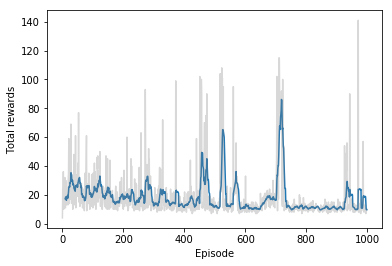

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

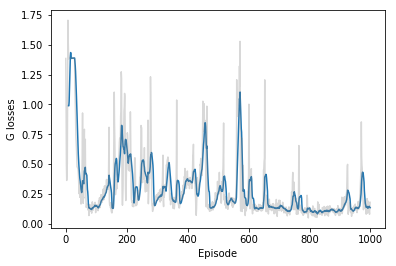

In [24]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

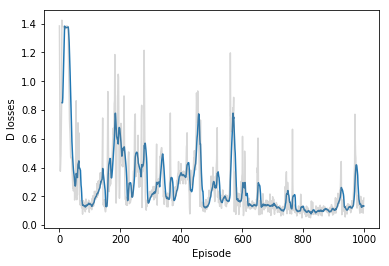

In [25]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [43]:
test_episodes = 1
test_max_steps = 20000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

# # # Create the env after closing it.
# # env = gym.make('CartPole-v0')
# # env = gym.make('Acrobot-v1')
# env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            
            # Rendering the env graphics
            env.render()
            
            # Get action from the model
            feed_dict = {model.prev_actions: np.array([prev_action]), 
                         model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, _, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                prev_action = env.action_space.sample()
                state, reward, done, _ = env.step(prev_action)
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


In [45]:
# Closing the env
# WARNING: If you close, you can NOT restart again!!!!!!
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.